**Google drive connection**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Extract ZIP file from Google Drive
!unzip "/content/drive/MyDrive/human_face.zip" -d /content/images

Mounted at /content/drive
Archive:  /content/drive/MyDrive/human_face.zip
   creating: /content/images/human_face/
  inflating: /content/images/human_face/chris_evans1.png  
  inflating: /content/images/human_face/chris_evans2.png  
  inflating: /content/images/human_face/chris_evans3.png  
  inflating: /content/images/human_face/chris_evans4.png  
  inflating: /content/images/human_face/chris_evans5.png  
  inflating: /content/images/human_face/chris_evans6.png  
  inflating: /content/images/human_face/chris_evans7.png  
  inflating: /content/images/human_face/chris_evans8.png  
  inflating: /content/images/human_face/chris_evans9.png  
  inflating: /content/images/human_face/chris_evans10.png  
  inflating: /content/images/human_face/chris_evans11.png  
  inflating: /content/images/human_face/chris_evans12.png  
  inflating: /content/images/human_face/chris_evans13.png  
  inflating: /content/images/human_face/chris_evans14.png  
  inflating: /content/images/human_face/chris_evans15.

**Importing importent Library**

In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

**Prepare the data**

In [3]:
class PolygonDataset(Dataset):
    def __init__(self, json_path, image_dir, resize=(128, 128), transform=None):
        with open(json_path, 'r') as f:
            self.data = json.load(f)

        self.image_dir = image_dir
        self.resize = resize
        self.transform = transform
        self.samples = []

        for fname, content in self.data.items():
            shape = content['regions']['0']['shape_attributes']
            x = shape['all_points_x'][:10]
            y = shape['all_points_y'][:10]
            if len(x) == 10 and len(y) == 10:
                self.samples.append((fname, x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname, x, y = self.samples[idx]
        image_path = os.path.join(self.image_dir, fname)
        image = Image.open(image_path).convert("RGB")
        w, h = image.size

        # Resize image
        image_resized = image.resize(self.resize)

        # Scale polygon
        scale_x, scale_y = self.resize[0] / w, self.resize[1] / h
        x_scaled = [pt * scale_x for pt in x]
        y_scaled = [pt * scale_y for pt in y]
        target = torch.tensor([p for pair in zip(x_scaled, y_scaled) for p in pair], dtype=torch.float32)

        if self.transform:
            image_resized = self.transform(image_resized)

        return image_resized, target


**Visualize Some Data**

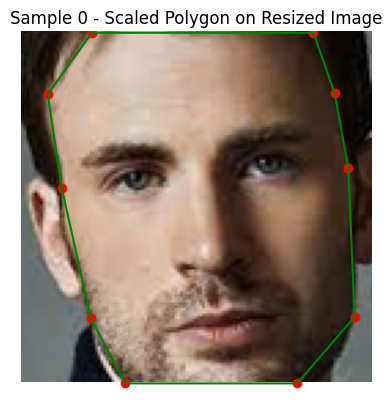

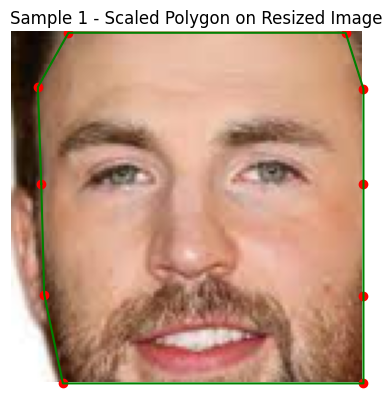

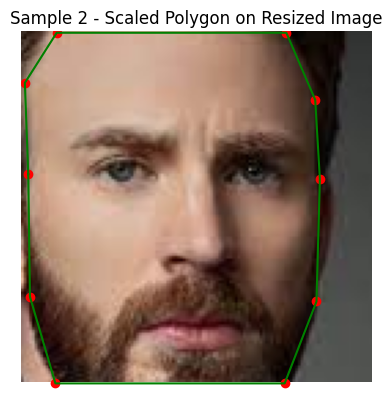

In [4]:
import matplotlib.pyplot as plt

# Create the dataset
transform = transforms.ToTensor()
dataset = PolygonDataset('/content/vgg.json', '/content/images/human_face/', resize=(128, 128), transform=transform)

# Show a few samples with their scaled polygons
for i in range(3):
    image_tensor, target = dataset[i]
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert CHW -> HWC
    points = target.view(-1, 2).numpy()           # Reshape to (10, 2)

    # Plot
    plt.imshow(image)
    plt.plot(*zip(*points, points[0]), 'g-')      # Polygon (green line)
    plt.scatter(*zip(*points), c='red')           # Points (red dots)
    plt.title(f"Sample {i} - Scaled Polygon on Resized Image")
    plt.axis('off')
    plt.show()


**Building a state of the art model**

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class PolygonUNetDownClassifier(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512], num_outputs=20):
        super(PolygonUNetDownClassifier, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.downs = nn.ModuleList()

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Regression Head
        self.clf1 = nn.Conv2d(features[-1]*2, 256, 3, 1, 1, bias=False)
        self.clf2 = nn.Conv2d(256, 32, 3, 1, 1, bias=False)
        self.clf3 = nn.Conv2d(32, 6, 3, 1, 1, bias=False)

        self.classifier = nn.Sequential(
            nn.Linear(6*8*8, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_outputs)
        )

    def forward(self, x):
        for down in self.downs:
            x = down(x)
            x = self.pool(x)
        x = self.bottleneck(x)

        c = self.clf1(x)
        c = self.clf2(c)
        c = self.clf3(c)
        c = c.view(c.size(0), -1)
        return self.classifier(c)

**Training Loop**

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = PolygonDataset('/content/vgg.json', '/content/images/human_face/', resize=(128, 128), transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
val_loader = DataLoader(val_set, batch_size=50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PolygonUNetDownClassifier().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
for epoch in range(200):
    model.train()
    total_loss = 0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        preds = model(images)
        loss = criterion(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 - Loss: 5863.2139
Epoch 2 - Loss: 5810.7321
Epoch 3 - Loss: 5697.3110
Epoch 4 - Loss: 5433.5442
Epoch 5 - Loss: 4924.8976
Epoch 6 - Loss: 4055.5586
Epoch 7 - Loss: 2961.4070
Epoch 8 - Loss: 2245.7618
Epoch 9 - Loss: 1581.8529
Epoch 10 - Loss: 948.9046
Epoch 11 - Loss: 487.3045
Epoch 12 - Loss: 245.2319
Epoch 13 - Loss: 114.0614
Epoch 14 - Loss: 73.4575
Epoch 15 - Loss: 60.4555
Epoch 16 - Loss: 57.0446
Epoch 17 - Loss: 51.7445
Epoch 18 - Loss: 45.9768
Epoch 19 - Loss: 42.9252
Epoch 20 - Loss: 41.4420
Epoch 21 - Loss: 42.4150
Epoch 22 - Loss: 43.3106
Epoch 23 - Loss: 40.3210
Epoch 24 - Loss: 41.0138
Epoch 25 - Loss: 38.4416
Epoch 26 - Loss: 41.0926
Epoch 27 - Loss: 38.7983
Epoch 28 - Loss: 39.2401
Epoch 29 - Loss: 39.3405
Epoch 30 - Loss: 38.6776
Epoch 31 - Loss: 40.0754
Epoch 32 - Loss: 38.3162
Epoch 33 - Loss: 38.8297
Epoch 34 - Loss: 37.1853
Epoch 35 - Loss: 38.8081
Epoch 36 - Loss: 37.1577
Epoch 37 - Loss: 38.1364
Epoch 38 - Loss: 38.1698
Epoch 39 - Loss: 36.2667
Epoch 40 - L

**Predicting Some image**

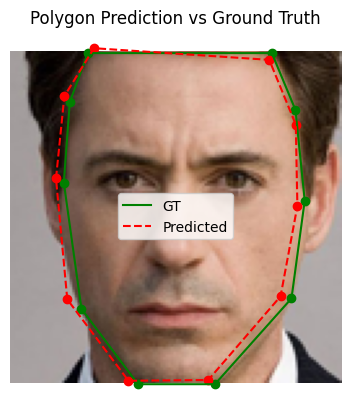

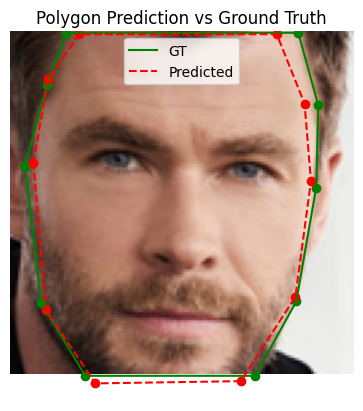

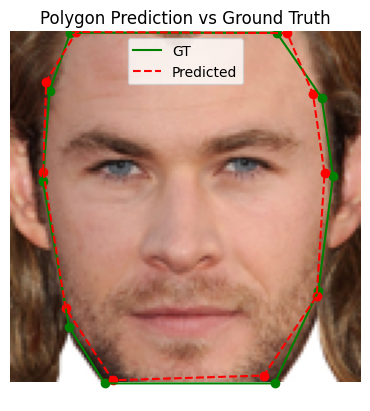

In [7]:
model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)

        for i in range(min(len(images), 3)):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            pred = outputs[i].cpu().reshape(-1, 2).numpy()
            true = targets[i].cpu().reshape(-1, 2).numpy()

            plt.imshow(img)
            plt.plot(*zip(*true, true[0]), 'g-', label='GT')
            plt.plot(*zip(*pred, pred[0]), 'r--', label='Predicted')
            plt.scatter(*zip(*true), c='green')
            plt.scatter(*zip(*pred), c='red')
            plt.title("Polygon Prediction vs Ground Truth")
            plt.legend()
            plt.axis('off')
            plt.show()
        break

**Putting Mask on the face**

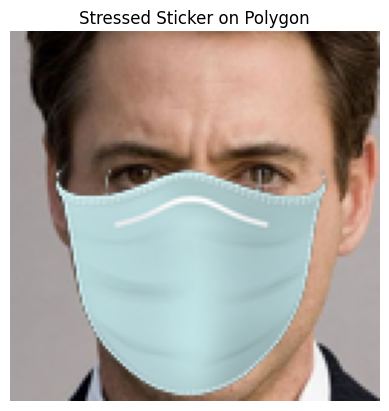

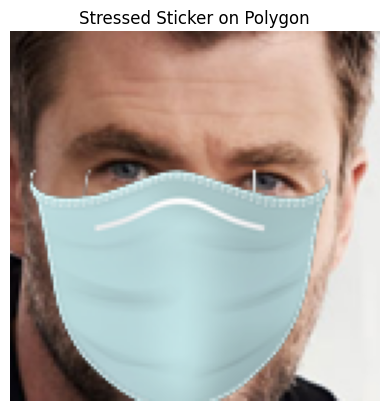

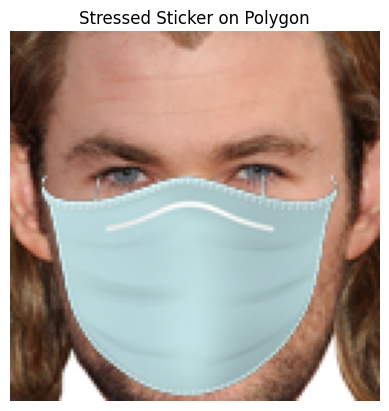

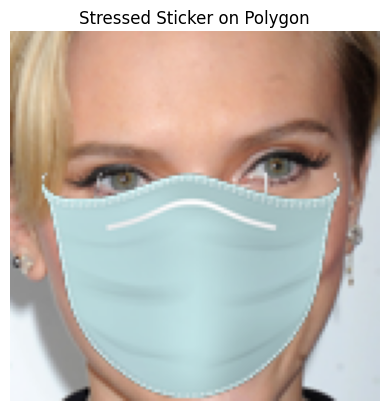

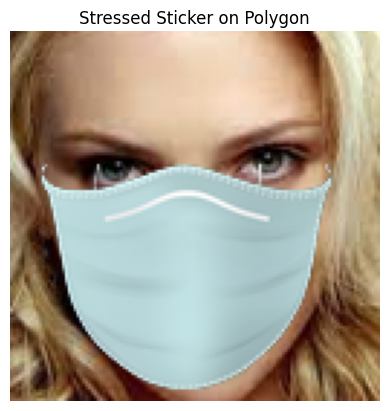

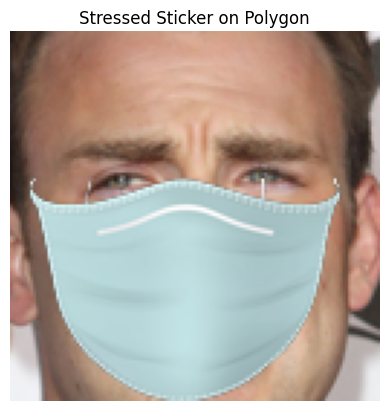

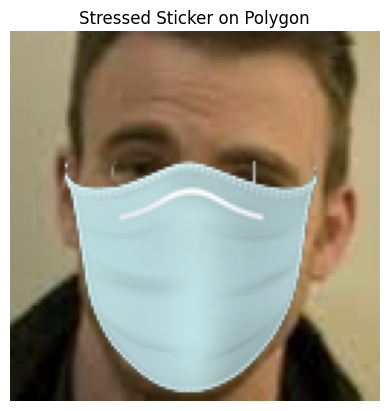

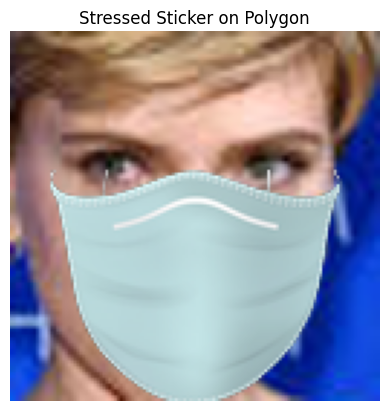

In [20]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

# Load transparent PNG sticker
sticker = Image.open("/content/a.png").convert("RGBA")

model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)

        for i in range(8):  # Show just one sample
            # Convert image tensor to PIL image
            image_tensor = images[i].cpu()
            img_np = (image_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            base_image = Image.fromarray(img_np).convert("RGBA")  # Ensure RGBA

            pred = outputs[i].cpu().reshape(-1, 2).numpy()

            # Use points 1,6,7,8,9,10 (0-based: 0,5,6,7,8,9)
            selected_indices = [0, 5, 6, 7, 8, 9]
            points = np.array([pred[idx] for idx in selected_indices], dtype=np.float32)

            # Bounding box of selected polygon
            min_x, min_y = np.min(points, axis=0)
            max_x, max_y = np.max(points, axis=0)

            width = max_x - min_x
            height = max_y - min_y

            # Apply a slight scale to "stress" the sticker
            scale_factor = 1.01  # 20% larger
            new_width = int(width * scale_factor)
            new_height = int(height * scale_factor)

            # Center the new sticker over the original polygon
            center_x = (min_x + max_x) / 2
            center_y = (min_y + max_y) / 2
            new_min_x = int(center_x - new_width / 2)
            new_min_y = int(center_y - new_height / 2)

            # Resize the sticker
            resized_sticker = sticker.resize((new_width, new_height), resample=Image.LANCZOS)

            # Create transparent canvas and paste sticker
            sticker_canvas = Image.new("RGBA", base_image.size, (0, 0, 0, 0))
            sticker_canvas.paste(resized_sticker, (new_min_x, new_min_y), resized_sticker)

            # Composite final image
            final_image = Image.alpha_composite(base_image, sticker_canvas)

            # Show
            plt.imshow(final_image)
            plt.title("Stressed Sticker on Polygon")
            plt.axis('off')
            plt.show()
        break


**Model Performance**

In [21]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    # Metrics
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)

    # Average Euclidean distance per point
    pred_points = all_preds.reshape(-1, 10, 2)
    target_points = all_targets.reshape(-1, 10, 2)
    distances = np.linalg.norm(pred_points - target_points, axis=2)  # shape: (N, 10)
    avg_euclidean = np.mean(distances)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Average Euclidean Distance": avg_euclidean
    }

In [23]:

train_metrics = evaluate_model(model, train_loader, device)
val_metrics = evaluate_model(model, val_loader, device)

print("Train Metrics:")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nValidation/Test Metrics:")
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics:
MSE: 5.0931
RMSE: 2.2568
MAE: 1.7485
Average Euclidean Distance: 2.7476

Validation/Test Metrics:
MSE: 25.7578
RMSE: 5.0752
MAE: 3.6751
Average Euclidean Distance: 5.8484


**Saving the trained model**

In [15]:
# Save the trained model
model_save_path = "/content/polygon_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/polygon_model.pth


In [17]:
model = PolygonUNetDownClassifier(num_outputs=20)
model.load_state_dict(torch.load("/content/polygon_model.pth"))
model.eval()

PolygonUNetDownClassifier(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): Ba

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from matplotlib.patches import Polygon

def predict_polygon_on_local_image(image_path, model, resize_dim=(128, 128), device='cpu'):
    # Step 1: Load the local image
    image = Image.open(image_path).convert("RGB")
    original_size = image.size  # (width, height)

    # Step 2: Preprocess the image
    transform = transforms.Compose([
        transforms.Resize(resize_dim),
        transforms.ToTensor()
    ])
    image_resized = transform(image).unsqueeze(0).to(device)

    # Step 3: Predict polygon (for resized image)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_resized)
        points = output.view(-1, 2).cpu().numpy()

    # Step 4: Rescale points to original image size
    scale_x = original_size[0] / resize_dim[0]
    scale_y = original_size[1] / resize_dim[1]
    points_original = [[x * scale_x, y * scale_y] for x, y in points]

    # Step 5: Plot image with transparent polygon mask
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Polygon overlay
    polygon_patch = Polygon(points_original, closed=True, edgecolor='red', facecolor='red', alpha=0.3)
    ax.add_patch(polygon_patch)

    # Optional: show polygon outline and points
    x_coords, y_coords = zip(*points_original)
    ax.plot(x_coords + (x_coords[0],), y_coords + (y_coords[0],), 'r--')  # outline
    ax.scatter(x_coords, y_coords, c='red')

    plt.axis('off')
    plt.title("Predicted Polygon on Local Image")
    plt.show()


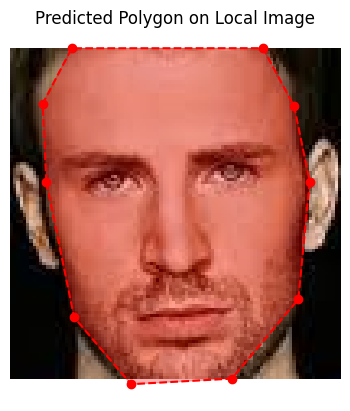

In [22]:
# Use this after you've loaded your model
image_path = "/content/1.png"
predict_polygon_on_local_image(image_path, model, resize_dim=(128, 128), device='cuda' if torch.cuda.is_available() else 'cpu')